# Progetto Machine Learning: Analisi Dataset Testuale


Il dataset è composto da mail ham e spam che, per mia scelta progettuale, vengono opportunamente caricate in un dataframe pandas.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import multiprocessing
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,precision_score,recall_score,roc_curve,auc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras import layers  
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import pickle as pkl
import warnings
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib
from sklearn.decomposition import PCA
import re
import string
import nltk
from nltk.corpus import stopwords
import gensim
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold,cross_validate
from sklearn.preprocessing import label_binarize
cores = multiprocessing.cpu_count()

In [2]:
PATH1="/home/emiliocasella/Scrivania/proj204898/testi-2/ham/"
PATH2="/home/emiliocasella/Scrivania/proj204898/testi-2/spam/"

In [3]:
def readFile(file):
    f = open(file, encoding="latin-1")
    return f.read()

def loadD(PATH1,PATH2):
    target=[]
    data=[]
    fnames1=glob.glob(PATH1+'*.txt')
    fnames2=glob.glob(PATH2+'*.txt')
    for f1 in fnames1:
        data.append(readFile(f1))
        target.append(0)#ham
    for f2 in fnames2:
        data.append(readFile(f2))
        target.append(1)#spam
    
    return pd.DataFrame(list(zip(data, target)), 
                        columns =['text', 'target']).sample(frac=1).reset_index(drop=True)
    

In [4]:
df=loadD(PATH1,PATH2)
df.head()

,text,target
0,Subject: fw : new generation report for june 2...,0
1,Subject: confirmation of meeting\nvince : than...,0
2,Subject: re : associate prc - input needed\ni ...,0
3,"Subject: re : gwen koepke\nanne ,\nthanks for ...",0
4,Subject: become a stud in bed\nfact :\nin a po...,1


In [5]:
df.to_pickle("/home/emiliocasella/Scrivania/proj204898/txt/original")

Le operazioni successive permettono di "ripulire" il testo da tutto ciò che viene considerato superfluo, al fine di consentire 
una migliore analisi.

In [4]:
def prep_text(text):
        text = text.lower()
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('https?://\S+|www\.\S+', '', text)
        text = re.sub('http?://\S+|www\.\S+', '', text)
        text = re.sub('href', '', text)
        text = re.sub('subject', '', text)
        text = re.sub('re', '', text)
        text = re.sub('<.*?>+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text)
        text = re.sub('\w*\d\w*', '', text)
        tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        text=tokenizer.tokenize(text)
        stop_words = stopwords.words('english')
        text=remove_stopwords(text,stop_words)
        return text
    
def remove_stopwords(text,stop_words):
    words = [w for w in text if w not in stop_words]
    return words

class MyTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self
    
    def transform(self, X,y):
        for c in y:
            for i in range(0,len(X[c])):
                X.at[i,c] =prep_text(X[c][i])

In [7]:
MyTokenizer().transform(df,['text'])
df.head()

,text,target
0,"[fw, new, generation, port, june, guys, intest...",0
1,"[confirmation, meetingvince, thanks, introduci...",0
2,"[associate, prc, input, neededi, houston, th, ...",0
3,"[gwen, koepkeanne, thanks, contacting, matter,...",0
4,"[become, stud, bedfact, poll, conducted, congl...",1


In [8]:
df.to_pickle("/home/emiliocasella/Scrivania/proj204898/txt/cleanwords")

Vengono ora mostrate le top 25 parole presenti per entrambe le tipologie di mail.

In [5]:
def contaP(tab,numW):
    words_freq={}
    data=[]
    frauTot = df[df['target'] == tab]
    text=frauTot['text']
    for i in text:
        for word in i:
            data.append(word)
    for key in data:
        if key not in words_freq:
            words_freq[key]=1
        else:
            words_freq[key]+=1
    sort=sorted(words_freq.items(), key=lambda x: x[1], reverse=True)
    return sort[:numW]

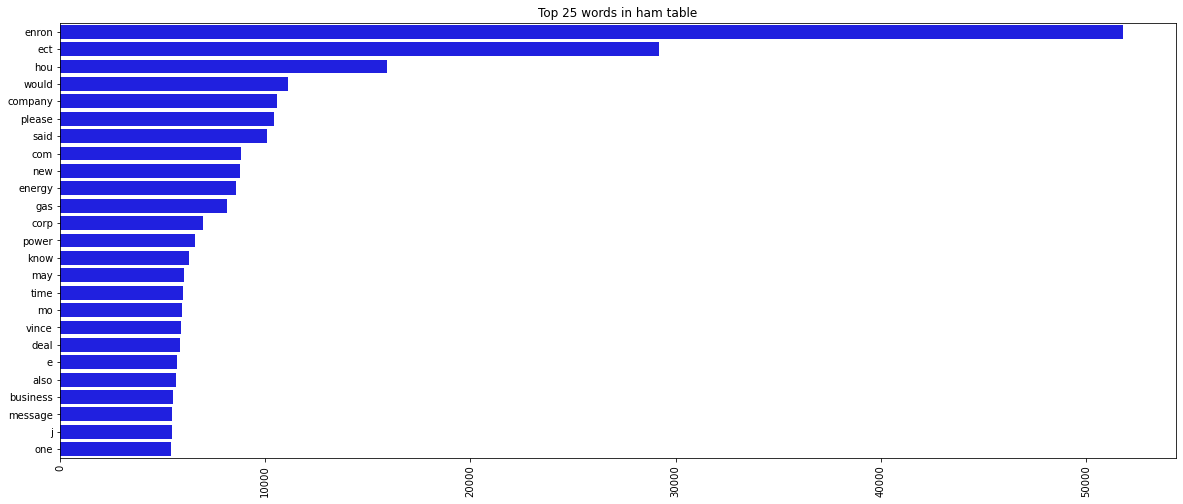

In [10]:
hamFreq=contaP(0,25)
plt.figure(1,figsize=(20,8))
plt.xticks(rotation='90')
x,y=map(list,zip(*hamFreq))
sns.barplot(x=y,y=x,color='blue')
plt.title('Top 25 words in ham table')
plt.show()

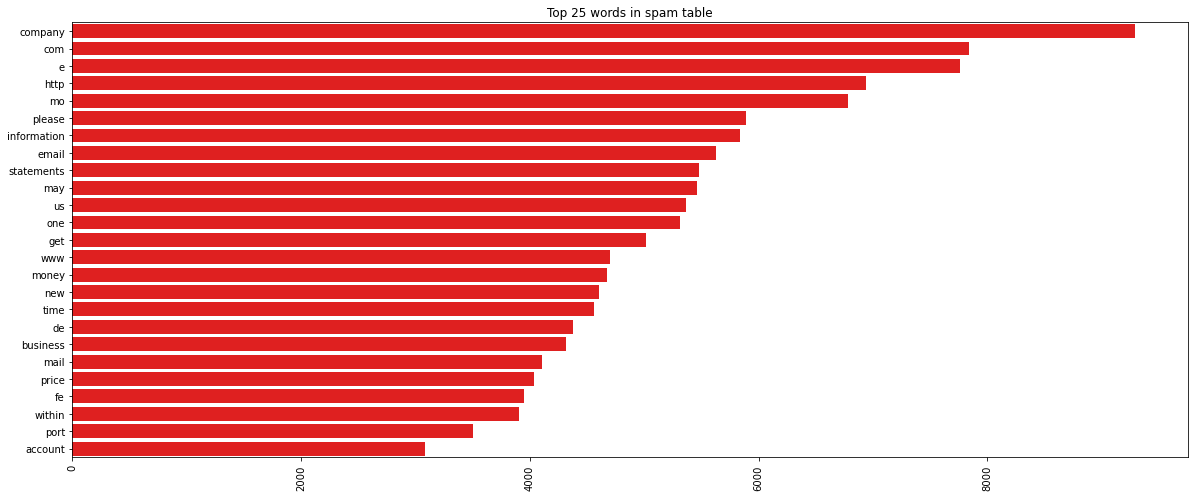

In [11]:
spamFreq=contaP(1,25)
plt.figure(1,figsize=(20,8))
plt.xticks(rotation='90')
x,y=map(list,zip(*spamFreq))
sns.barplot(x=y,y=x,color='red')
plt.title('Top 25 words in spam table')
plt.show()

Si crea un embeddings per la tabella nel seguente modo:

1) Creo un dizionario contenente al max le 200 parole più frequenti per entrambe le tipologie di mail;

2) Creo un vettore che, per ogni file, analizza le parole e la converte con l'indice che la rappresenta nel dizionario, se questa è presente, altrimenti col valore zero;

Otterrò, per il dataset in esame, una rappresentazione vettoriale di grandezza 305.

In [6]:
def cleanV(elements):
    modificata = np.zeros(305)
    for e in elements:
        modificata = np.vstack((modificata, e))
    return modificata[1:]

def createIndex(numWords):
    indexWords={}
    words=[]
    topWHam=contaP(0,numWords)
    topWSpam=contaP(1,numWords)
    for i in range(len(topWHam)):
        words.append(topWHam[i][0])
    for i in range(len(topWSpam)):
        words.append(topWSpam[i][0])
    i=0
    for word in words:
        if word not in indexWords:
            indexWords[word]=i
            i=i+1
    return indexWords

def createEmbeddings(text,indexWords):
    vector=np.zeros(len(indexWords),dtype=int)
    for word in text:
        if word in indexWords:
            i=indexWords[word]
            if(vector[i]==0):
                vector[i]=1
            else:
                vector[i]=vector[i]+1
    return vector

class MyEmbeddings(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self
    
    def transform(self, X,y):
        index=createIndex(200)
        for c in y:
            for i in range(0,len(X[c])):
                X.at[i,c] =createEmbeddings(X[c][i],index)

In [13]:
MyEmbeddings().transform(df,['text'])
df.head()

,text,target
0,"[1, 0, 0, 1, 0, 1, 0, 1, 6, 0, 0, 0, 3, 0, 0, ...",0
1,"[0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 1, 0, 1, ...",0
2,"[18, 10, 4, 2, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0...",0
3,"[2, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...",1


In [14]:
df.to_pickle("/home/emiliocasella/Scrivania/proj204898/txt/embeddings")

In [15]:
def saveM(model,fname):
    fname=fname+'.model'
    pkl.dump(model, open(fname, 'wb'))

def loadM(fname):
    return pkl.load(open(fname+'.model', 'rb'))

def saveNN(model,fname):
    json_model = model.to_json()
    open(fname + '.json', 'w').write(json_model)
    model.save_weights(fname + '.h5', overwrite=True)

def loadNN(fname):
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model = model_from_json(open(fname+'.json').read())
    model.load_weights(fname+'.h5')
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [16]:
X=cleanV(df['text'].to_numpy())
y=df.target.to_numpy()

## Rete Neurale 

La rete neurale, che verrà utilizzata, sfrutta vari livelli densi, particolarmente indicati in questa casistica.
Si utilizza una loss 'binary_crossentropy', mentre l'ultimo layer utilizza una funzione di attivazione sigmoidale, ottima nella classificazione binaria.

La seconda rete presentata, verrà utilizzata per analizzare l'embeddings Doc2vec.

In [37]:
def create_network():
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model = Sequential()
    model.add(keras.layers.Dense(128, activation='relu',input_dim=305))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_network2():
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model = Sequential()
    model.add(keras.layers.Dense(256, activation='relu',input_dim=500))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    return model



def tuningNN(X_train, X_test, y_train, y_test,epochs,typeC):
    if(typeC==0):
        model = create_network()
    else:
        model = create_network2()
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.000001)
    history=model.fit(X_train,y_train,epochs=epochs,validation_data = (X_test,y_test),callbacks=[reduce_lr],verbose=1)
  
   
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

     

class MyClassificatorTrainNN(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self

    def transform(self, X,y,epochs,typeC):
        print("Preprocessing per NN...")
        X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                        test_size=0.2,shuffle=True) 
        print("Tuning NN...")
        tuningNN(X_train, X_test, y_train, y_test,epochs,typeC)
        print("Fatto!") 

Viene studiata la loss su una divisione di prova per 20 epoche, per capire il numero necessario al training del modello. Per evitare fenomeni di overfitting, il tutto viene controllato dalla funzione ReduceLROnPlateau che, non appena la rete smette di apprendere, abbassa il learning rate.

Preprocessing per NN...
Tuning NN...
Epoch 1/20
793/793 [==============================] - 2s 2ms/step - loss: 0.5144 - accuracy: 0.7453 - val_loss: 0.1834 - val_accuracy: 0.9450
Epoch 2/20
793/793 [==============================] - 1s 2ms/step - loss: 0.1603 - accuracy: 0.9467 - val_loss: 0.1339 - val_accuracy: 0.9585
Epoch 3/20
793/793 [==============================] - 1s 1ms/step - loss: 0.1144 - accuracy: 0.9611 - val_loss: 0.1196 - val_accuracy: 0.9623
Epoch 4/20
793/793 [==============================] - 1s 1ms/step - loss: 0.0977 - accuracy: 0.9648 - val_loss: 0.1123 - val_accuracy: 0.9648
Epoch 5/20
793/793 [==============================] - 1s 1ms/step - loss: 0.0868 - accuracy: 0.9678 - val_loss: 0.1072 - val_accuracy: 0.9677
Epoch 6/20
793/793 [==============================] - 1s 2ms/step - loss: 0.0803 - accuracy: 0.9710 - val_loss: 0.1095 - val_accuracy: 0.9663
Epoch 7/20
793/793 [==============================] - 1s 2ms/step - loss: 0.0728 - accuracy: 0.9758 - val_loss:

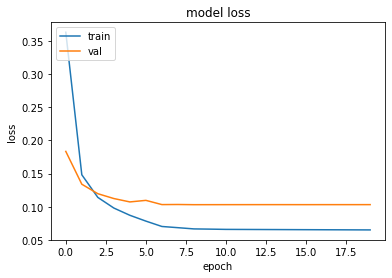

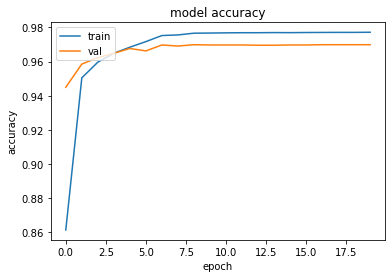

Fatto!


In [61]:
MyClassificatorTrainNN().transform(X,y,20,0)

La scelta ricade su 20 epoche.

## Tuning dei modelli SVC,ADABOOST e KNN 

Le restanti tipologie di classificatori, con annessi passaggi, sono i medesimi affrontati per l'analisi del dataset precedente, non necessitando di ulteriori spiegazioni.

In [11]:
def tuningAdaBoostClassifier(X_train,y_train):
    param_ada_grid={'n_estimators':[10,50,100,500],
                    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0],
                   }
    ada=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm='SAMME.R')
    grid_search=GridSearchCV(ada,param_ada_grid,scoring='accuracy',n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Param:", grid_search.best_params_)
    best_ada = grid_search.best_estimator_
    return best_ada


def tuningKNN(X_train,y_train,knn):
    params = {'n_neighbors': range(1, 21, 2),
              'weights':['uniform','distance'],
              'metric':['euclidean', 'manhattan', 'minkowski']
             }
    grid_search = GridSearchCV(knn, params,scoring='accuracy',n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Param:", grid_search.best_params_)
    best_KNN = grid_search.best_estimator_
    return best_KNN

def tuningSVC(X_train,y_train,svc):
    param_svc_grid ={'kernel': ['poly', 'linear', 'rbf','sigmoid'],
                      'C' : [500, 300 ,200, 150, 100, 50, 10, 1],
                     'gamma': ['scale']
                    }
    grid_search = GridSearchCV(svc, param_svc_grid,scoring='accuracy',n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Param:", grid_search.best_params_)
    best_svc = grid_search.best_estimator_
    return best_svc


class MyClassificatorTrain(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self

    def transform(self, X,y):
        X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                     test_size=0.2,shuffle=True)
        print("Training modelli...")
        print("AdaBoost...")
        ada_best=tuningAdaBoostClassifier(X_train,y_train)
        print("Tuning SVC...")
        svc_clf=SVC()
        svc_best = tuningSVC(X_train,y_train,svc_clf)
        print("Tuning KNN...")
        knn_clf=KNeighborsClassifier()
        knn_best=tuningKNN(X_train,y_train,knn_clf)
        print("Fatto!")
      

In [18]:
MyClassificatorTrain().transform(X,y)

Training modelli...
AdaBoost...
Best Param: {'learning_rate': 1.0, 'n_estimators': 500}
Tuning SVC...
Best Param: {'C': 200, 'gamma': 'scale', 'kernel': 'rbf'}
Tuning KNN...
Best Param: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Fatto!


# Accuratezza sulla 10-fold cross-validation

In [19]:
strkf=StratifiedKFold(n_splits=10)
score_KFold=[]

In [29]:
def confusionMat(clf,X_test,y_test,typeC):
    if(typeC==0):
        pred = clf.predict(X_test)
    else:
        pred=(clf.predict(X_test) > 0.5).astype("int32")
    score=accuracy_score(y_test, pred)
    ax =sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='.1f', cmap=sns.color_palette("Reds", 25))
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    print(classification_report(y_test, pred))
    y_test,pred=label_binarize(y_test, classes=[0,1,2,3]),label_binarize(pred, classes=[0,1,2,3])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(2):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Roc Curve class ' + str(i))
        plt.legend(loc="lower right")
        plt.show()

def compute_performance(estimator,strkf,X, y):
    score = cross_validate(estimator, X ,y,cv=strkf ,scoring='accuracy',return_estimator=True,n_jobs=-1)
    model=score['estimator']
    results=score['test_score']
    mean_accuracy=np.round(np.mean(results),3)
    mean_std= np.round(np.std(results),3)
    maxAcc=np.round((np.max(results)),3)
    argMaxAcc=np.argmax(results)
    saveM(model[argMaxAcc],estimator.__class__.__name__)
    print("L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore ")
    print(results)
    print("Ottenendo un'accuratezza media di " + str(mean_accuracy)+" con deviazione standard di "+ str(mean_std))
    print("La migliore accuratezza e' "+ str(maxAcc) + " ottenuta nello split numero " + str(argMaxAcc+1))
    print("Salvo il modello ottenuto nello split numero " + str(argMaxAcc+1))
    print("Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero " + str(argMaxAcc+1))
    test_fold=[]
    for train_index, test_index in strkf.split(X, y):
            test_fold.append(test_index)
    confusionMat(model[argMaxAcc],X[test_fold[argMaxAcc]],y[test_fold[argMaxAcc]],0)
    return (mean_accuracy,mean_std)


def compute_performance_nn(estimator,strkf,X,y,fname):
    model_fold=[]
    test_fold=[]
    acc_fold=[]
    loss_fold=[]
    fold_no = 1
    for train, test in strkf.split(X,y):
            if(fname=="NN2DV"):
                model=create_network2()
            else:
                model = create_network()
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.000001)
            history=model.fit(X[train],y[train],epochs=20,validation_data = (X[test],y[test]),callbacks=[reduce_lr],verbose=0)
            scores = model.evaluate(X[test], y[test], verbose=0)
            acc_fold.append(scores[1])
            loss_fold.append(scores[0])
            test_fold.append(test)
            model_fold.append(model)
            fold_no = fold_no + 1
    mean_accuracy=np.round(np.mean(acc_fold),3)
    mean_std= np.round(np.std(acc_fold),3)
    maxAcc=np.round((np.max(acc_fold)),3)
    argMaxAcc=np.argmax(acc_fold)
    print('Score per fold')
    saveNN(model_fold[argMaxAcc],fname)
    print("L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore ")
    print(acc_fold)
    print("Ottenendo un'accuratezza media di " + str(mean_accuracy)+" con deviazione standard di "+ str(mean_std))
    print("La migliore accuratezza e' "+ str(maxAcc) + " ottenuta nello split numero " + str(argMaxAcc+1))
    
    
    
    print("Salvo il modello ottenuto nello split numero " + str(argMaxAcc+1))
    print("Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero " + str(argMaxAcc+1))
    confusionMat(model_fold[argMaxAcc],X[test_fold[argMaxAcc]],y[test_fold[argMaxAcc]],1)##0
    return (mean_accuracy,mean_std)


L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore 
[0.96278776 0.95868811 0.95425868 0.9615142  0.96088328 0.95425868
 0.96277603 0.96119874 0.95615142 0.95741325]
Ottenendo un'accuratezza media di 0.959 con deviazione standard di 0.003
La migliore accuratezza e' 0.963 ottenuta nello split numero 1
Salvo il modello ottenuto nello split numero 1
Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero 1


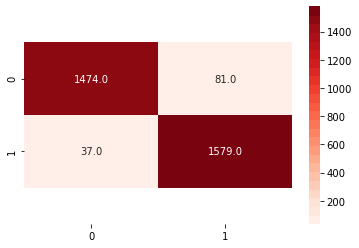

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1555
           1       0.95      0.98      0.96      1616

    accuracy                           0.96      3171
   macro avg       0.96      0.96      0.96      3171
weighted avg       0.96      0.96      0.96      3171



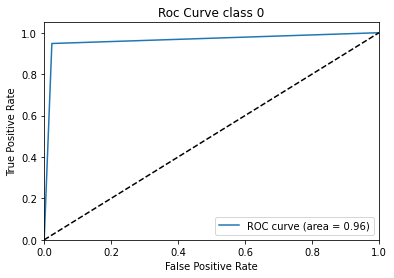

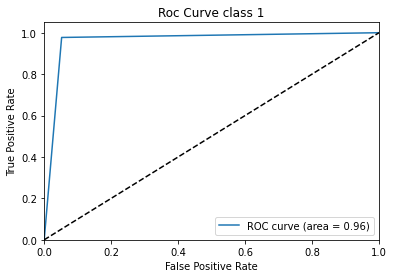

In [13]:
clf_ada=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=500, learning_rate=1.0,algorithm='SAMME.R')
mean_ada,std_ada=compute_performance(clf_ada,strkf,X, y)
score_KFold.append((mean_ada,std_ada))

L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore 
[0.9640492  0.95931883 0.95457413 0.96214511 0.96214511 0.9533123
 0.96246057 0.96119874 0.95835962 0.95930599]
Ottenendo un'accuratezza media di 0.96 con deviazione standard di 0.003
La migliore accuratezza e' 0.964 ottenuta nello split numero 1
Salvo il modello ottenuto nello split numero 1
Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero 1


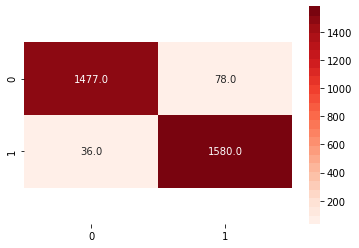

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1555
           1       0.95      0.98      0.97      1616

    accuracy                           0.96      3171
   macro avg       0.96      0.96      0.96      3171
weighted avg       0.96      0.96      0.96      3171



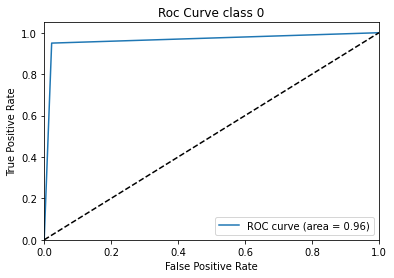

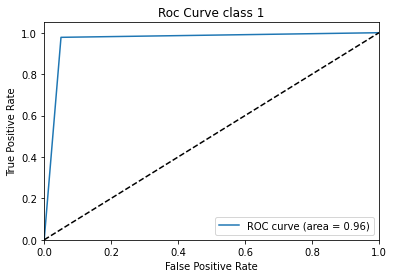

In [14]:
clf_svc=SVC(kernel='rbf', C=200, gamma='scale')
mean_svc,std_svc=compute_performance(clf_svc,strkf,X, y)
score_KFold.append((mean_svc,std_svc))

L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore 
[0.92210659 0.92336802 0.9148265  0.92681388 0.92807571 0.91514196
 0.92082019 0.92176656 0.929653   0.92586751]
Ottenendo un'accuratezza media di 0.923 con deviazione standard di 0.005
La migliore accuratezza e' 0.93 ottenuta nello split numero 9
Salvo il modello ottenuto nello split numero 9
Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero 9


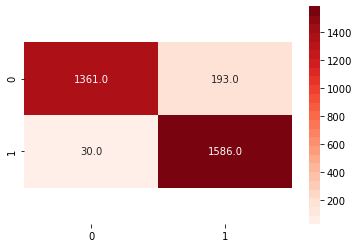

              precision    recall  f1-score   support

           0       0.98      0.88      0.92      1554
           1       0.89      0.98      0.93      1616

    accuracy                           0.93      3170
   macro avg       0.93      0.93      0.93      3170
weighted avg       0.93      0.93      0.93      3170



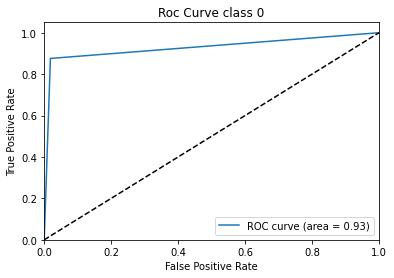

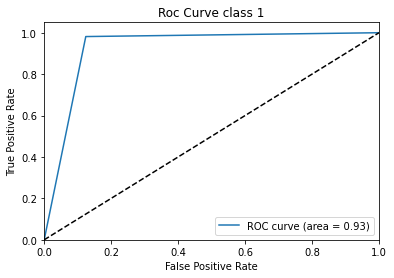

In [15]:
clf_knn=KNeighborsClassifier(n_neighbors=9, weights='distance',metric='euclidean')
mean_knn,std_knn=compute_performance(clf_knn,strkf,X, y)
score_KFold.append((mean_knn,std_knn))

Score per fold
L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore 
[0.9722484946250916, 0.968464195728302, 0.960567831993103, 0.970346987247467, 0.9646687507629395, 0.9596214294433594, 0.9706624746322632, 0.9662460684776306, 0.9630914926528931, 0.9649842381477356]
Ottenendo un'accuratezza media di 0.966 con deviazione standard di 0.004
La migliore accuratezza e' 0.972 ottenuta nello split numero 1
Salvo il modello ottenuto nello split numero 1
Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero 1


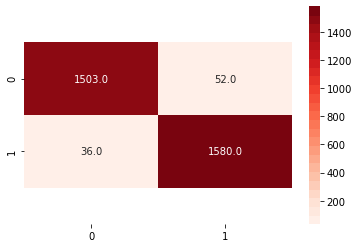

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1555
           1       0.97      0.98      0.97      1616

    accuracy                           0.97      3171
   macro avg       0.97      0.97      0.97      3171
weighted avg       0.97      0.97      0.97      3171



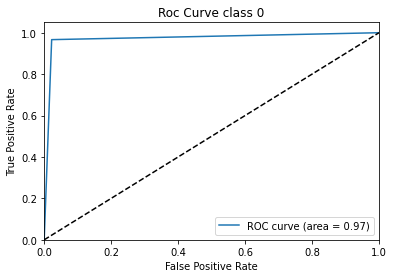

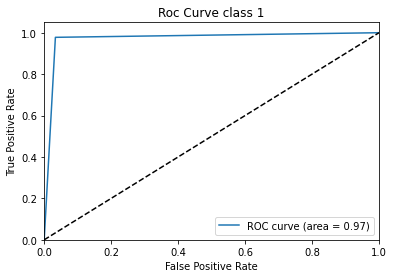

In [17]:
clf_nn=KerasClassifier(build_fn=create_network)
mean_nn,std_nn=compute_performance_nn(clf_nn,strkf,X, y,"NN")
score_KFold.append((mean_nn,std_nn))

Da tutti i risultati e grafici precedenti, si evince come la rete neurale rappresenti il miglior modello.

## Embeddings tramite Doc2Vec

Vediamo ora, come si comporta il miglior modello ottenuto, utilizzando un embeddings ricavato da una rete neurale tipicamente utilizzata per l'analisi testuale: Doc2Vec.

Prima di inoltrarsi nella spiegazione di come effettivamente questo approccio sia stato utilizzato per gli scopi da noi prefissati, è necessario fornire un breve background teorico. Doc2Vec in realtà è un metodo derivante dal più noto Word2Vec che consiste in un gruppo di modelli che sono usati per effettuare del word embedding, ovvero
una traduzione di parole o frasi in vettori composti da numeri reali. Questi modelli non sono altro che delle reti neurali a due livelli che sono addestrate (tramite un approccio non supervisionato) per ricostruire i contesti linguistici delle parole. Word2Vec prende come input un grande frammento di testo e costruisce uno spazio vettoriale assegnata ad un corrispondente vettore nello spazio, seguendo un certo criterio. Infatti i vettori (rappresentanti le parole) vengono posizionati nello spazio cosicché le parole che risultino "simili" all’interno del frammento di testo, siano collocate vicine tra loro nello spazio stesso.
L’idea infatti è quella di riuscire ad incapsulare relazioni differenti tra le parole, comead esempio sinonimi, contrari o analogie.

Il vero obiettivo sarà quello di imparare i pesi del livello di hidden, così da usarli come codifica di ogni singola parola (word vector).
Nello specifico, esistono due metodologie per poter creare il modello che permette la
codifica delle parole in vettori:

• Skip-Gram model: in cui si prendono coppie di parole dal testo e si addestra una rete neurale con un livello di
nodi di hidden sulla base del finto task in cui, a partire da una parola in input, la rete restituisce la distribuzione di probabilità delle parole vicine (all’interno del testo) all’input. In altre parole, la rete restituirà alte probabilità per le parole che tipicamente compaiono "vicine" alla parola in input. Essendo un finto task però, ad essere realmente importanti saranno i pesi tra i nodi di input e i nodi di hidden che saranno usati come word embedding. Quindi se lo strato di hidden
possiede 300 neuroni, la rete restituirà un vettore di dimensione pari a 300, per ciscuna parola;

• A continuous bag of words (CBOW): anch’essa fa uso di una rete neurale con un livello di nodi di hidden. Il finto task in questo caso è basato sul predire una parola centrale, a partire da un insieme di parole di input (appartenenti allo
stesso contesto). Anche qui, saranno poi i pesi tra il livello di input e di hidden ad essere usati come word embeddings per i termini dati in ingresso alla rete.


L’obiettivo del Doc2Vec è di creare una
rappresentazione numerica di un intero documento (o paragrafo, nel nostro caso di un
tweet) a prescindere dalla sua lunghezza. Il principio usato è semplice ed intelligente:
si fa uso del modello word2vec e si aggiunge un altro vettore, detto Paragraph ID.

Quindi dopo aver addestrato la rete neurale, si avranno oltre che i word vectors (la
rappresentazione vettoriale delle parole) anche un document vector (la rappresentazione
vettoriale del documento).

Anche nel caso del Doc2Vec esistono due metodologie analoghe rispettivamente al
CBOW e lo Skip-Grim:

• Distributed Memory version of Paragraph Vector (PV-DM): che agisce
come una memoria che ricorda cosa manca esattamente all’interno del contesto in
questione o come l’argomento del paragrafo. Mentre i word vectors rappresentano
il concetto di una parola, il document vector intende rappresentare il concetto di
un documento.

• Distributed Bag of Words version of Paragraph Vector (PV-DBOW):
che risulta essere più veloce e che consuma meno memoria (contrariamente a
quanto accade allo skip-gram nel word2vec) in quanto non c’è alcun bisogno di
salvarsi i word vectors (rappresentazioni vettoriali delle parole). Dopo l’addestramento infatti, basta fornire il paragraph ID (detto anche tag) per ricevere il
document vector.

Si utilizzerà l'algoritmo PV-DBOW, con un vettore di taglia 500 per rappresentare il documento.
La predizione avrà una finestra di 2 parole e si utilizzeranno 10 epoche di train.

In [18]:
df_doc2vec=pd.read_pickle("/home/emiliocasella/Scrivania/proj204898/txt/cleanwords")
words=df_doc2vec.text.to_list()
target=df_doc2vec.text.to_numpy()
documents = [TaggedDocument(words[i], target[i]) for i in range(len(target))]
model = gensim.models.Doc2Vec(documents, vector_size=500, window=2,epochs=10, min_count=1, workers=cores)
model.save('d2vec'+'.model')   
print("Fatto!")

Fatto!


In [23]:
def cleanV2(elements):
    modificata = np.zeros(500)
    for e in elements:
        modificata = np.vstack((modificata, e))
    return modificata[1:]

def convert_mean(text,model):
    vectors=model.infer_vector(text)
    return vectors

class MyDoc2vec(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y,model):
        return self
    
    def transform(self, X,y,fname):
        model = gensim.models.Doc2Vec.load(fname)
        for c in y:
            for i in range(0,len(X[c])):
                X.at[i,c] =convert_mean(X[c][i],model)

In base al modello di embeddings creato, si ottiene la seguente conversione per ogni documento.

In [20]:
MyDoc2vec().transform(df_doc2vec,['text'],"d2vec.model")
df_doc2vec.head()

,text,target
0,"[0.17600273, -0.33752394, 0.10832454, -0.03667...",0
1,"[-0.2561136, 0.08447421, 0.090536326, -0.05035...",0
2,"[-0.8033857, 0.3208517, 0.7965166, -0.14490508...",0
3,"[-0.3176085, 0.45610327, 0.20239797, 0.3979420...",0
4,"[-0.74756914, 0.009872089, -0.020475907, 1.624...",1


In [21]:
df_doc2vec.to_pickle("/home/emiliocasella/Scrivania/proj204898/txt/d2vecinferred")

In [24]:
X_doc2vec=cleanV2(df_doc2vec['text'].to_numpy())
y_doc2vec=df_doc2vec.target.to_numpy()

La rete neurale utilizzata come classificatore è simile alla precedente, con l'aggiunta di un primo livello a 256, avendo a che fare con un vettore di dimensione maggiore.

Score per fold
L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore 
[0.9757174253463745, 0.9728792309761047, 0.960567831993103, 0.9801262021064758, 0.9675078988075256, 0.969085156917572, 0.9637224078178406, 0.967823326587677, 0.9706624746322632, 0.9709779024124146]
Ottenendo un'accuratezza media di 0.97 con deviazione standard di 0.005
La migliore accuratezza e' 0.98 ottenuta nello split numero 4
Salvo il modello ottenuto nello split numero 4
Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero 4


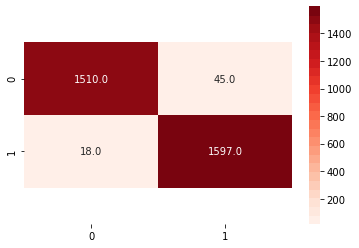

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1555
           1       0.97      0.99      0.98      1615

    accuracy                           0.98      3170
   macro avg       0.98      0.98      0.98      3170
weighted avg       0.98      0.98      0.98      3170



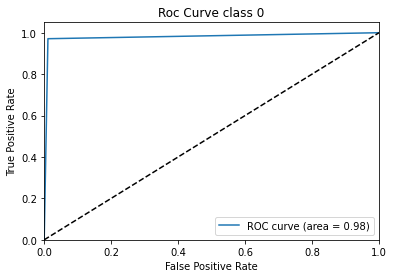

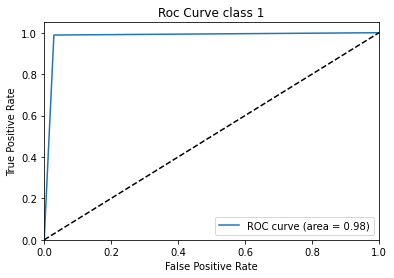

In [40]:
clf_nn=KerasClassifier(build_fn=create_network)
mean_nn,std_nn=compute_performance_nn(clf_nn,strkf,X_doc2vec, y_doc2vec,"NN2DV")
score_KFold.append((mean_nn,std_nn))

Si noti come un embeddings di questo tipo, abbinato ad una buona rete neurale, permetta di ottenere risultati migliori.

In [47]:
score_df = pd.DataFrame(score_KFold,index=['AdaBoost','SVC','KNN','NN','D2VNN'],columns=['accuracy_mean','std'])
score_df.to_csv("/home/emiliocasella/Scrivania/proj204898/img/10fold.csv")
score_df.head()

,accuracy_mean,std
AdaBoost,0.959,0.003
SVC,0.960,0.003
KNN,0.923,0.005
NN,0.966,0.004
D2VNN,0.970,0.005


In [52]:
def tenFoldPlot(score_KFold,labels):
    values=[]
    for i,j in score_KFold:
        values.append(i)
        values.append(j)  
    plt.figure()
    c=['yellow','red','green','blue','orange']
    data=np.array(values).reshape(len(labels),2)
    accuracy=data[:,0]
    stdr=data[:,1]
    std=data[:,1]/np.max(data[:,1])
    size=[50]*10  
    for i in range(len(c)):
        l=labels[i]
        acc=accuracy[i]
        sx=stdr[i]
        plt.scatter([acc],[acc],s=std[i]*acc*3000,color=[c[i]])
        st1="{0} Acc:{1:.2f}%".format(l,acc*100.0)
        st2="{0}std:{1:.3f}".format(" ",sx)
        plt.scatter([], [], color=[c[i]], s=std[i]*200,
                label=st1+" "+st2)
    plt.grid(linestyle="--")
    plt.legend(loc='lower left', bbox_to_anchor=(0.4, 1),
          ncol=1, fancybox=True, shadow=True)
    plt.axis([np.min(accuracy)-.05, np.max(accuracy)+.05,np.min(accuracy)-.05, np.max(accuracy)+.05])
    plt.show()

Come si evince da tutti i risultati  e i grafici precedenti, il modello migliore per accuratezza è rappresentato dalla rete neurale con embeddings Doc2Vec, seguita da NN,SVC, KNN e AdaBoost ottenuti sulla prima tipologia di embeddings.

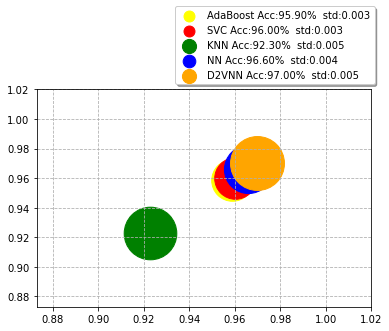

In [53]:
labels=score_df.index.values
tenFoldPlot(score_KFold,labels)

## Anomaly Detection

Come richiesto dalla traccia progettuale, si cerca di identificare la classe più numerosa classificandola come corretta; le restanti classi rappresenteranno le anomalie.

Si mostra, tramite il grafico sottostante, che la classe ham è quella che contiene più esempi.

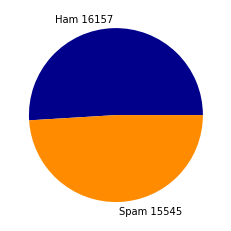

In [54]:
dataFrame=pd.read_pickle("/home/emiliocasella/Scrivania/proj204898/txt/embeddings")
pie=dataFrame['target'].value_counts()
correctData=dataFrame[dataFrame['target']==1]
anomalyData=dataFrame[dataFrame['target']==0]
labels=["Ham "+str(pie[1]),"Spam "+str(pie[0])]
plt.pie(pie, labels=labels,colors=['darkblue','darkorange'])
plt.show()



Si applica PCA sulla prima tipologia di embeddings:

In [64]:
def bestPCA(correctData_X_train,correctData_X_test,anomalyData_X,correctData_y_test,anomalyData_y,number):
    indexR=[]
    roc=[]
    for i in range (0,number,2):
        model = PCA(n_components=i)
        model.fit(correctData_X_train)
        values=np.concatenate((correctData_X_test,anomalyData_X))
        labels=np.concatenate((correctData_y_test,anomalyData_y))
        predictions=model.inverse_transform(model.transform(values))
        roc.append(roc2(values,predictions,labels))
        indexR.append(i)
    return indexR[np.argmax(roc)]

def plotErrAnom(correct_error,anomaly_error):
    plt.plot(correct_error,color="green",label='Errors')
    plt.plot(np.arange(len(correct_error),len(correct_error)+len(anomaly_error)),anomaly_error,color="red",label='Anomaly')
    plt.legend(loc="upper left")
    plt.show()
    
def mean_squared_err(true,pred):
    err=[]
    col=true.shape[1]
    true=list(true)
    pred=list(pred)
    for i in range(len(true)):
        p=pred[i]
        t=true[i]
        e=p-t
        e=e**2
        e=np.sum(e)
        e=e/col
        err.append(e)
    return np.array(err)  

def roc(values,predictions,labels):
    error= mean_squared_err(values,predictions)
    roc_x=[]
    roc_y=[]
    roc=0
    oldfpr=0
    oldtpr=0
    steps=100
    scaler = MinMaxScaler(feature_range=(0,1))
    error =1- scaler.fit_transform(error.reshape(-1,1))
    fpr,tpr,th=metrics.roc_curve(labels,error)
    for i in range(len(fpr)):
        FPR,TPR=fpr[i],tpr[i]
        roc+=(TPR+oldtpr)*(FPR-oldfpr)/2
        oldfpr=FPR
        oldtpr=TPR
        roc_x.append(FPR)
        roc_y.append(TPR)        
    plt.plot([0]+roc_x, [0]+roc_y, label='ROC curve (area = %0.3f)' % roc)
    plt.plot([0,1], [0,1], linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower left")
    plt.show()
    return roc


def roc2(values,predictions,labels):
    error= mean_squared_err(values,predictions)
    roc_x=[]
    roc_y=[]
    roc=0
    oldfpr=0
    oldtpr=0
    steps=100
    scaler = MinMaxScaler(feature_range=(0,1))
    error =1- scaler.fit_transform(error.reshape(-1,1))
    fpr,tpr,th=metrics.roc_curve(labels,error)
    for i in range(len(fpr)):
        FPR,TPR=fpr[i],tpr[i]
        roc+=(TPR+oldtpr)*(FPR-oldfpr)/2
        oldfpr=FPR
        oldtpr=TPR
        roc_x.append(FPR)
        roc_y.append(TPR)        
    return roc

class MyClassificatorAnomaly(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, correctData, anomalyData):
        return self

    def transform(self, correctData, anomalyData,typeC):
        correctData_y=correctData.target.to_numpy()
        correctData_X=cleanV(correctData['text'].to_numpy())
        correctData_X_train,correctData_X_test,correctData_y_train,correctData_y_test=train_test_split(correctData_X,correctData_y,test_size=0.2,shuffle=True)
        anomalyData_y=anomalyData.target.to_numpy()
        anomalyData_X=cleanV(anomalyData['text'].to_numpy())
        anomalyData_X_train,anomalyData_X_test,anomalyData_y_train,anomalyData_y_test=train_test_split(anomalyData_X,anomalyData_y,test_size=0.2,shuffle=True)
        print("Tuning anomaly detections with PCA...")
        if(typeC):
            best=bestPCA(correctData_X_train,correctData_X_test,anomalyData_X,correctData_y_test,anomalyData_y,305)
        else:
            best=bestPCA(correctData_X_train,correctData_X_test,anomalyData_X,correctData_y_test,anomalyData_y,500)
        print("Best PCA values "+ str(best))
        model = PCA(n_components=best)
        model.fit(correctData_X_train)
        predicted_correct=model.inverse_transform(model.transform(correctData_X_test))
        predicted_anomaly=model.inverse_transform(model.transform(anomalyData_X))
        correct_error= mean_squared_err(correctData_X_test,predicted_correct)
        anomaly_error= mean_squared_err(anomalyData_X,predicted_anomaly)
        values=np.concatenate((correctData_X_test,anomalyData_X))
        labels=np.concatenate((correctData_y_test,anomalyData_y))
        predictions=model.inverse_transform(model.transform(values))
        print("done!")
        return model,correct_error,anomaly_error,values,predictions,labels

La migliore configurazione è con 256 features.

In [56]:
model,correct_error,anomaly_error,values,predictions,labels=MyClassificatorAnomaly().transform(correctData, anomalyData,305)

Tuning anomaly detections with PCA...
Best PCA values 256
done!


Il modello non commette errore, quasi nullo sulla classe corretta, presentando un buon risultato.

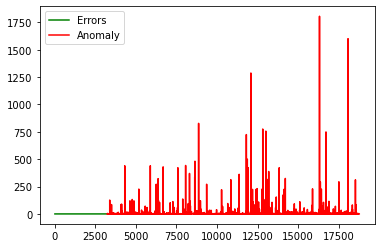

In [57]:
plotErrAnom(correct_error,anomaly_error)

La curva di ROC conferma tutto questo,mostrando un risultato altamente accurato.

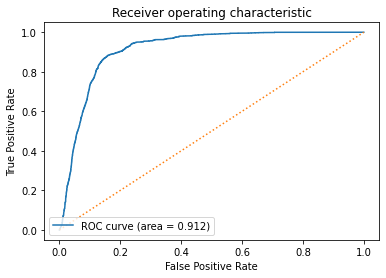

0.9122813259333354

In [58]:
roc(values,predictions,labels)

Si passa ora all'analisi PCA sulla rappresentazione tramite Doc2Vec:

In [66]:
dataFrame2=pd.read_pickle("/home/emiliocasella/Scrivania/proj204898/txt/d2vecinferred")
correctData=dataFrame[dataFrame['target']==1]
anomalyData=dataFrame[dataFrame['target']==0]

La migliore configurazione è con 278 features.

In [67]:
model2,correct_error2,anomaly_error2,values2,predictions2,labels2=MyClassificatorAnomaly().transform(correctData, anomalyData,500)

Tuning anomaly detections with PCA...
Best PCA values 278
done!


Anche in questo caso,il modello non commette errore, quasi nullo, sulla classe corretta, presentando un buon risultato.

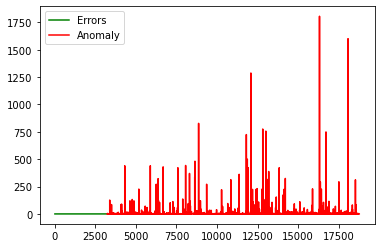

In [68]:
plotErrAnom(correct_error,anomaly_error)

La curva di ROC conferma tutto questo,mostrando un risultato altamente accurato, leggermente migliore di quello precedente.

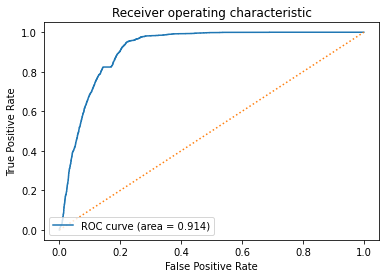

0.9139228991048058

In [69]:
roc(values2,predictions2,labels2)

Si salva il modello ottenuto dalla 2 configurazione.

In [70]:
saveM(model,"BestAnomayModel")